# 1. Постановка задачі та підготовка даних

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
ds = pd.read_csv('../data/calories.csv')

In [3]:
ds.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


<Axes: >

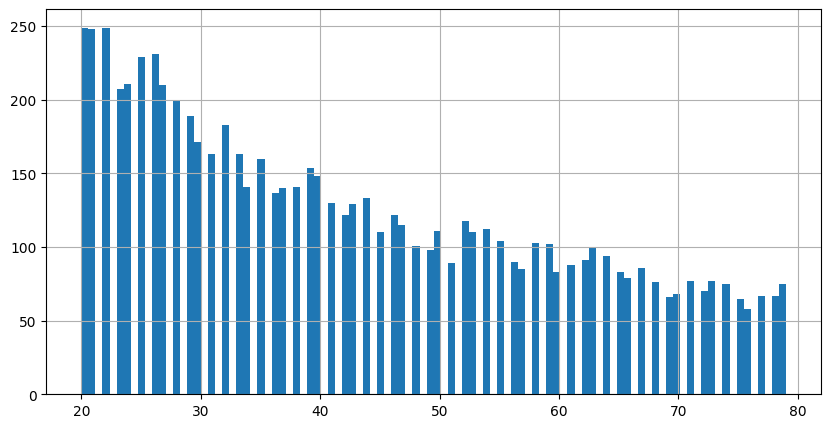

In [5]:
ds[ds['Gender'] == 'female']['Age'].hist(bins=100, figsize=(10, 5))

In [ ]:
# one-hot using pd (works but cliche)
# ds = pd.get_dummies(ds, columns=['Gender'], drop_first=True)

In [6]:
# works!
encoder = LabelEncoder()
ds['Gender'] = encoder.fit_transform(ds['Gender'])

In [7]:
ds.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0


In [108]:
ds = ds.drop('User_ID', axis=1)

In [8]:
X = ds.drop('Calories', axis=1)
y = ds['Calories']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape[0], X_test.shape[0]

(12000, 3000)

In [11]:
X_train.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

## 😳

In [12]:
scaler = StandardScaler()
scale_data = lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

In [13]:
X_train

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
9839,16554569,1,37,179.0,77.0,7.0,81.0,39.5
9680,18903739,1,23,195.0,87.0,26.0,110.0,40.5
7093,11938260,1,33,181.0,77.0,12.0,88.0,40.1
11293,14116395,0,66,156.0,54.0,9.0,77.0,39.5
820,13815395,0,32,144.0,49.0,5.0,90.0,39.0
...,...,...,...,...,...,...,...,...
5191,11890347,0,75,148.0,51.0,22.0,104.0,40.6
13418,13504073,0,21,172.0,67.0,20.0,104.0,40.7
5390,17918506,1,57,189.0,92.0,8.0,90.0,39.5
860,12133833,1,35,174.0,76.0,12.0,97.0,40.2


# II. Розв’язання задачі ймовірнісної регресії

1. Навчити регресійні моделі (наприклад, лінійну регресію, випадковий ліс, 
градієнтний бустинг).
2. Додати ймовірнісні межі (min/max) для кожного прогнозу (наприклад, 
довірчі інтервали 95%) використовуючи підхід на ваш вибір.
3. Перевірити якість регресійної моделі за допомогою метрик:
• MAE (Mean Absolute Error)
• RMSE (Root Mean Square Error)
• R² (коефіцієнт детермінації)
4. Оптимізувати гіперпараметри моделі (наприклад, кількість дерев у 
випадку Random Forest).
5. Повторно валідувати модель після оптимізації та оцінити зміни.


In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import statsmodels.api as sm
import matplotlib.pylab as plt

class MetricsManager:
  @staticmethod
  def print_metrics(y_test, y_pred, prefix_str="") -> list[float, float, float]:
    mae = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("{} - MAE: {:.3f}, RMSE: {:.3f}, R^2: {:.3f}".format(prefix_str, mae, rmse, r2))
    return [mae, rmse, r2]
  @staticmethod
  def confidence_intervals(X_train_scaled, y_train, X_test_scaled):
    X_train_sm = sm.add_constant(X_train_scaled)
    X_test_sm = sm.add_constant(X_test_scaled)

    model = sm.OLS(y_train, X_train_sm).fit()
    pred_sm = model.get_prediction(X_test_sm)
    pred_summary = pred_sm.summary_frame(alpha=0.05) # 95% interval
    #display(pred_summary.head())
    pred_summary.head()
    return pred_summary
  @staticmethod
  def visualise_metrics(y_test, y_pred, pred_summary, title="", values_num=50) -> None:
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.values[:values_num], 'bo-', label='Real Values')
    plt.plot(y_pred[:values_num], 'ro-', label='Predicted Values')
    plt.fill_between(
      np.arange(values_num),
      pred_summary['obs_ci_lower'][:values_num],
      pred_summary['obs_ci_upper'][:values_num],
      color='gray', alpha=0.2, label='95%'
    )
    plt.legend()
    plt.xlabel('Record Index')
    plt.ylabel('Target')
    plt.title(title)
    plt.show()
    
  @staticmethod
  def print_classification_metrics(y_true, y_pred, model_name) -> tuple:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred))
    print('\nClassification Report:\n', classification_report(y_true, y_pred))
    return acc, prec, rec, f1

In [111]:
def check_model_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test) -> tuple[str, list[int, int, int]]:
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  
  model_name = type(model).__name__
  mae, rmse, r2 = MetricsManager.print_metrics(y_test, y_pred, model_name)
  pred_summary = MetricsManager.confidence_intervals(X_train_scaled, y_train, X_test_scaled)
  MetricsManager.visualise_metrics(y_test, y_pred, pred_summary, title=f"{model_name} predictions 95% percentile", values_num=100)
  return model_name, [mae, rmse, r2]
  

In [112]:
metrics_map = {}
def checker_wrapper(model) -> None:
  model_name, metrics = check_model_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test)
  metrics_map[model_name] = metrics 

In [113]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [114]:
y_pred = model.predict(X_test_scaled)
MetricsManager.print_metrics(y_test, y_pred, "Linear Regression")

Linear Regression - MAE: 138.167, RMSE: 11.754, R^2: 0.966


[138.16707086101633, 11.75444898159911, 0.9657645664705375]

In [115]:
lr_lower = LinearRegression()
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

In [122]:
lr_lower.fit(X_train_sm, y_train)
pred_sm = lr_lower.predict(X_test_sm)
pred_summary = pred_sm.summary_frame(alpha=0.05) # 95% interval
pred_summary

AttributeError: 'numpy.ndarray' object has no attribute 'summary_frame'

In [121]:
MetricsManager.visualise_metrics(y_test, y_pred, pred_summary, title="LR predictions 95% percentile")

NameError: name 'pred_summary' is not defined

In [123]:
models = []

In [124]:
lr_model = LinearRegression()
models.append(lr_model)
check_model_metrics(lr_model, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression - MAE: 138.167, RMSE: 11.754, R^2: 0.966


AttributeError: type object 'OLS' has no attribute 'get_prediction'

In [23]:
from sklearn.linear_model import Lasso
ls_model = Lasso(random_state=42)
models.append(ls_model)
check_model_metrics(ls_model, X_train_scaled, y_train, X_test_scaled, y_test)

Lasso - MAE: 165.677, RMSE: 12.872, R^2: 0.959


('Lasso', [165.67687364724767, 12.871552884063666, 0.9589481085487798])

In [24]:
from sklearn.linear_model import Ridge
ridge_model = Ridge()
models.append(ridge_model)
check_model_metrics(ridge_model, X_train_scaled, y_train, X_test_scaled, y_test)

Ridge - MAE: 138.180, RMSE: 11.755, R^2: 0.966


('Ridge', [138.17987495354586, 11.754993617758618, 0.9657613938357269])

In [25]:
from sklearn.linear_model import ElasticNet
elastic_model = ElasticNet()
models.append(elastic_model)
check_model_metrics(elastic_model, X_train_scaled, y_train, X_test_scaled, y_test)

ElasticNet - MAE: 420.365, RMSE: 20.503, R^2: 0.896


('ElasticNet', [420.36538397362295, 20.50281405011573, 0.8958406581869831])

In [26]:
from sklearn.linear_model import BayesianRidge
bayes_model = BayesianRidge()
models.append(bayes_model)
check_model_metrics(bayes_model, X_train_scaled, y_train, X_test_scaled, y_test)

BayesianRidge - MAE: 138.171, RMSE: 11.755, R^2: 0.966


('BayesianRidge', [138.1705902175247, 11.754598683814123, 0.965763694434277])

In [27]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
models.append(rf_model)
check_model_metrics(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

RandomForestRegressor - MAE: 9.496, RMSE: 3.081, R^2: 0.998


('RandomForestRegressor',
 [9.495565500000001, 3.0814875466241953, 0.9976471615163145])

In [28]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(tree_method="hist", early_stopping_rounds=2)
#check_model_metrics(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)
# xgb_model.fit(X_train_scaled, y_train)

In [29]:
from catboost import CatBoostRegressor 
cat_model = CatBoostRegressor()
models.append(cat_model)
check_model_metrics(cat_model, X_train_scaled, y_train, X_test_scaled, y_test)

Learning rate set to 0.06063
0:	learn: 58.7876314	total: 133ms	remaining: 2m 13s
1:	learn: 55.6330751	total: 147ms	remaining: 1m 13s
2:	learn: 52.6671971	total: 158ms	remaining: 52.5s
3:	learn: 49.8422989	total: 172ms	remaining: 42.9s
4:	learn: 47.2500117	total: 184ms	remaining: 36.7s
5:	learn: 44.7295965	total: 198ms	remaining: 32.9s
6:	learn: 42.3682425	total: 206ms	remaining: 29.2s
7:	learn: 40.0843673	total: 212ms	remaining: 26.3s
8:	learn: 37.9864623	total: 217ms	remaining: 23.9s
9:	learn: 36.0210642	total: 221ms	remaining: 21.9s
10:	learn: 34.1275729	total: 227ms	remaining: 20.4s
11:	learn: 32.4469302	total: 231ms	remaining: 19s
12:	learn: 30.7938772	total: 236ms	remaining: 17.9s
13:	learn: 29.2273172	total: 243ms	remaining: 17.1s
14:	learn: 27.7614328	total: 247ms	remaining: 16.2s
15:	learn: 26.3495847	total: 251ms	remaining: 15.4s
16:	learn: 25.0233332	total: 256ms	remaining: 14.8s
17:	learn: 23.8011500	total: 260ms	remaining: 14.2s
18:	learn: 22.6341571	total: 265ms	remaining:

('CatBoostRegressor',
 [2.077488926107886, 1.4413496890442257, 0.9994852338289092])

KNeighborsRegressor - MAE: 53.381, RMSE: 7.306, R^2: 0.987


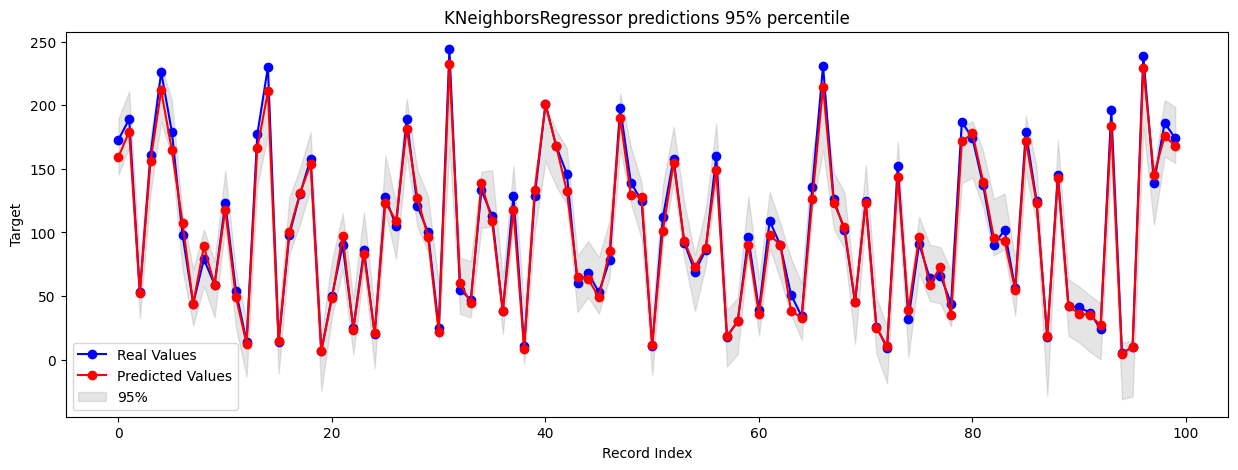

('KNeighborsRegressor',
 [53.38053333333333, 7.306198281824367, 0.986773218182074])

In [126]:
from sklearn.neighbors import KNeighborsRegressor
kn_model = KNeighborsRegressor()
models.append(kn_model)
check_model_metrics(kn_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [31]:
for model in models:
  checker_wrapper(model)

LinearRegression - MAE: 138.167, RMSE: 11.754, R^2: 0.966
Lasso - MAE: 165.677, RMSE: 12.872, R^2: 0.959
Ridge - MAE: 138.180, RMSE: 11.755, R^2: 0.966
ElasticNet - MAE: 420.365, RMSE: 20.503, R^2: 0.896
BayesianRidge - MAE: 138.171, RMSE: 11.755, R^2: 0.966
RandomForestRegressor - MAE: 9.691, RMSE: 3.113, R^2: 0.998
Learning rate set to 0.06063
0:	learn: 58.7876314	total: 13ms	remaining: 13s
1:	learn: 55.6330751	total: 23.3ms	remaining: 11.6s
2:	learn: 52.6671971	total: 33.1ms	remaining: 11s
3:	learn: 49.8422989	total: 43.1ms	remaining: 10.7s
4:	learn: 47.2500117	total: 53.5ms	remaining: 10.7s
5:	learn: 44.7295965	total: 63.5ms	remaining: 10.5s
6:	learn: 42.3682425	total: 74.6ms	remaining: 10.6s
7:	learn: 40.0843673	total: 85.7ms	remaining: 10.6s
8:	learn: 37.9864623	total: 95.7ms	remaining: 10.5s
9:	learn: 36.0210642	total: 105ms	remaining: 10.4s
10:	learn: 34.1275729	total: 116ms	remaining: 10.4s
11:	learn: 32.4469302	total: 125ms	remaining: 10.3s
12:	learn: 30.7938772	total: 136ms	

In [32]:
metrics_df = pd.DataFrame(metrics_map).T
metrics_df.rename({
  0: "mae",
  1: "rmse",
  2: "r2",
}, axis=1, inplace=True)
metrics_df

,mae,rmse,r2
LinearRegression,138.167071,11.754449,0.965765
Lasso,165.676874,12.871553,0.958948
Ridge,138.179875,11.754994,0.965761
ElasticNet,420.365384,20.502814,0.895841
BayesianRidge,138.170590,11.754599,0.965764
RandomForestRegressor,9.691428,3.113106,0.997599
CatBoostRegressor,2.077489,1.441350,0.999485
KNeighborsRegressor,53.380533,7.306198,0.986773


our competitors have assembled now let us choose the worsiest one💥

In [33]:
metrics_df['mae'].sort_values()

CatBoostRegressor          2.077489
RandomForestRegressor      9.691428
KNeighborsRegressor       53.380533
LinearRegression         138.167071
BayesianRidge            138.170590
Ridge                    138.179875
Lasso                    165.676874
ElasticNet               420.365384
Name: mae, dtype: float64

In [34]:
metrics_df['rmse'].sort_values()

CatBoostRegressor         1.441350
RandomForestRegressor     3.113106
KNeighborsRegressor       7.306198
LinearRegression         11.754449
BayesianRidge            11.754599
Ridge                    11.754994
Lasso                    12.871553
ElasticNet               20.502814
Name: rmse, dtype: float64

In [35]:
metrics_df['r2'].sort_values(ascending=False)

CatBoostRegressor        0.999485
RandomForestRegressor    0.997599
KNeighborsRegressor      0.986773
LinearRegression         0.965765
BayesianRidge            0.965764
Ridge                    0.965761
Lasso                    0.958948
ElasticNet               0.895841
Name: r2, dtype: float64

alright, choosing the best ones'd be boring so lets choose three models at random and tune them

In [36]:
import random
random.choices(models, k=3)

[Lasso(random_state=42), RandomForestRegressor(), BayesianRidge()]

I got these
1. ElasticNet(), 
2. LinearRegression(), 
3. BayesianRidge()

### pipes🐱‍👤

we'll get back to the gridSearch in a minute I just wanna try using pipes

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [40]:
ds = pd.read_csv('../data/calories.csv')
X = ds
y = ds['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
num_cols = [n for n in ds.columns if n != 'Gender' and n != 'Calories']
cat_cols = ['Gender']

In [42]:
num_preprocessor = Pipeline([
  ('scaler', StandardScaler())
])
cat_preprocessor = Pipeline([
  ('one_hot_encoder', OneHotEncoder())
])

In [43]:
preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_preprocessor, num_cols),
    ('cat', cat_preprocessor, cat_cols)
  ]
)

In [44]:
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', lr_model)
])

In [45]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', LinearRegression())])

In [46]:
mae, rmse, r2 = MetricsManager.print_metrics(y_test, y_pred, "pipe")

pipe - MAE: 138.167, RMSE: 11.754, R^2: 0.966


I guess it look all nice and clean but I kinda feel uneasy cause of that X=ds thing above.

and also I can't see the interprocess results which's like being blind(((

### GridSearch comes back

Let me remind you of our dear participants
1. ElasticNet(), 
2. LinearRegression(), 
3. BayesianRidge()

I'll not use pipe for this as I am not so sure whether I know about it good enough yet

In [47]:
ds = pd.read_csv('../data/calories.csv')

encoder = LabelEncoder()
ds['Gender'] = encoder.fit_transform(ds['Gender'])

X = ds.drop('Calories', axis=1)
y = ds['Calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scale_data = lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

our data is back

#### Linear Regressor

In [48]:
lr_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

eeeehh, I knew u couldn't really tune but like...

#### KNeighborsRegressor      

In [49]:
kn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [50]:
from sklearn.metrics import make_scorer

scoring = {
  'mae': make_scorer(mean_absolute_error),
  'msre': make_scorer(mean_squared_error),
  'r2': make_scorer(r2_score)
}

In [51]:
from sklearn.model_selection import GridSearchCV
kn_grid = GridSearchCV(
  estimator=kn_model,
  param_grid={
    'n_neighbors': [5, 10, 15]
  },
  cv=3,
  scoring=scoring,
  refit='r2'     # but why for gods sake
)

In [52]:
kn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 15]}, refit='r2',
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'msre': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

In [53]:
pd.DataFrame(kn_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,split2_test_msre,mean_test_msre,std_test_msre,rank_test_msre,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.061995,0.003296,0.273919,0.024695,5,{'n_neighbors': 5},5.296250,5.364650,5.237650,5.299517,...,51.095430,53.375850,2.179860,1,0.985940,0.985782,0.986856,0.986193,0.000474,3
1,0.077814,0.007967,0.330684,0.114563,10,{'n_neighbors': 10},4.942550,5.089025,5.015125,5.015567,...,47.951952,48.800640,2.227701,3,0.987572,0.986908,0.987665,0.987382,0.000337,1
2,0.056053,0.017716,0.401489,0.027115,15,{'n_neighbors': 15},4.911867,5.067400,5.011167,4.996811,...,48.830058,49.857558,2.578303,2,0.987374,0.986517,0.987439,0.987110,0.000420,2


#### ElasticNet

In [54]:
elastic_model.get_params()


{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [55]:
elastic_grid = GridSearchCV(
  estimator=elastic_model,
  param_grid={
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': [750, 1000, 1250],
    'selection': ['cyclic', 'random'],
  },
  cv=3,
  # scoring=scoring,
  # refit=False     # but why for gods sake
)
elastic_grid.fit(X_train_scaled, y_train)
res = pd.DataFrame(elastic_grid.cv_results_)

In [56]:
res['params'][15]

{'l1_ratio': 0.75, 'max_iter': 1000, 'selection': 'random'}

#### Bayesian Ridge

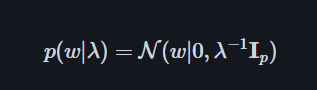

шо не ясно

In [57]:
bayes_model.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': 300,
 'tol': 0.001,
 'verbose': False}

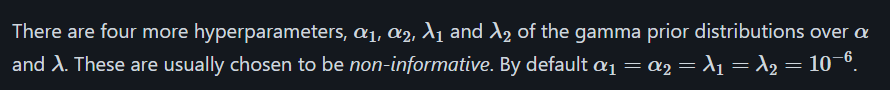

well, default it is then

# III. Дослідження ансамблевих методів

1. Використати ансамблеві моделі для покращення результатів:
• Bagging (Random Forest)
• Boosting (XGBoost, Gradient Boosting)
• Stacking (поєднання кількох моделей)
2. Додати ймовірнісні межі (min/max) для кожного прогнозу
3. Порівняти результати ансамблів із базовими моделями.

as both RF and CatBoost were used let's try stacking🐱‍👤

я зайшов на оф. доки і ооооо пайпи згодились

I'll use the same models as in the docs

In [90]:
lasso_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', Lasso()),
])
lasso_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', Lasso())])

In [91]:
rf_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', RandomForestRegressor(n_estimators=10))
])
rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', RandomForestRegressor(n_estimators=10))])

oi, they use some gradient boosting regressor

In [60]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [61]:
boosting_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', HistGradientBoostingRegressor(random_state=0))
])
boosting_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', HistGradientBoostingRegressor(random_state=0))])

but I also wanna ad my Elastic model🐱‍👤

In [62]:
elastic_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', ElasticNet(
    l1_ratio=0.75, 
    max_iter=1000,
    selection='random',
  ))
])
elastic_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', ElasticNet(l1_ratio=0.75, selection='random'))])

stacking time🎂

In [63]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [64]:
estimators = [
  ('Lasso', lasso_pipe),
  ('Random Forest', rf_pipe),
  ('ElasticNet', elastic_pipe),
  ('Gradient Boosting', boosting_pipe),
]

In [67]:
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('scaler',
                                                                                                  StandardScaler())]),
                                                                                 ['User_ID',
                                                                                  'Age',
                                                                                  'Height',
                                                                                  'Weight',
                                                                                  'Duration',
                                                                                  'Heart_Rate',
                                                                                  'Body_Temp']),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('one_hot_encoder',
                                                                                                  OneHotEncoder())]),
                                                                                 ['Gender'])])),
                                               ('model', Lasso())])),
                              ('Random Forest',
                               Pipeline...
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('scaler',
                                                                                                  StandardScaler())]),
                                                                                 ['User_ID',
                                                                                  'Age',
                                                                                  'Height',
                                                                                  'Weight',
                                                                                  'Duration',
                                                                                  'Heart_Rate',
                                                                                  'Body_Temp']),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('one_hot_encoder',
                                                                                                  OneHotEncoder())]),
                                                                                 ['Gender'])])),
                                               ('model',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

nooooowww let's copy and paste entire script from these fancy docs of theirs

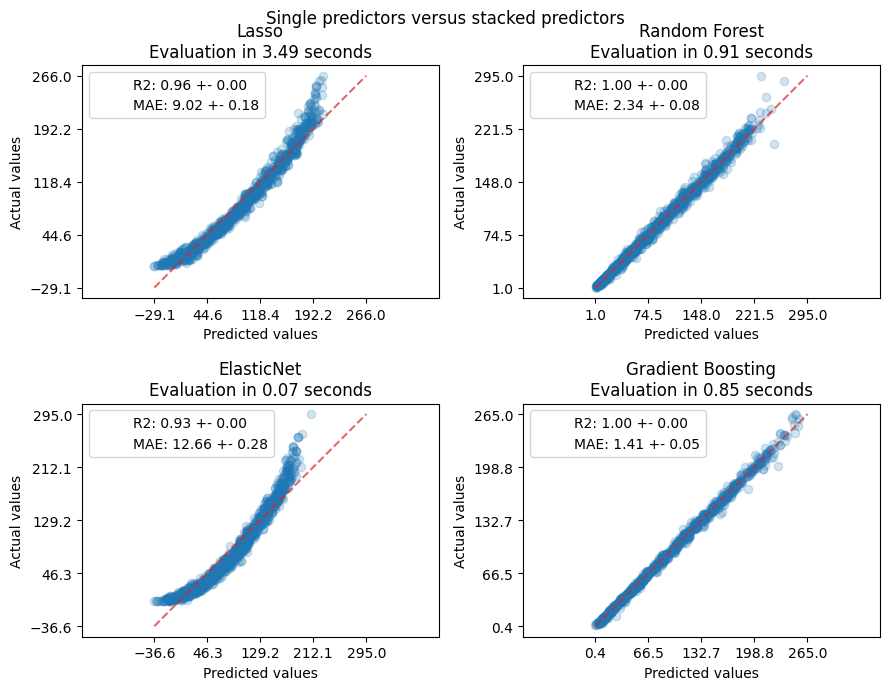

In [68]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X_train_scaled, y_train, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    # i'm using test data for prediction
    y_pred = cross_val_predict(est, X_test_scaled, y_test, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }
    # MetricsManager.confidence_intervals(X_train_scaled, y_train, X_test_scaled)

    display = PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

what if we use my func?

In [69]:
stacking_regressor.predict(X_test_scaled)

NotFittedError: This StackingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

I'm too tired to deal with this, let's move on for now and I'll come back to it later

confidence intervals? ☕☕☕

# IV. Перехід від регресії до класифікації

1. Перетворити регресію на класифікацію, розбивши цільову змінну на 
класи з використанням рівномірного поділу (дискретизації)(Equal-width 
binning)
2. Навчити класифікатори (наприклад, логістичну регресію, дерево рішень, 
XGBoost).
3. Оцінити якість класифікації за метриками:
• Accuracy (точність класифікації)
• Precision, Recall, F1-score
• Confusion Matrix
4. Повторити кроки 1-3 використовуючи інший крок дискретизації та 
порівняти результати


In [70]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 4
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

In [71]:
y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class = kbd.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

In [72]:
pd.Series(y_train_class).value_counts()

0    6072
1    3867
2    1936
3     125
Name: count, dtype: int64

In [73]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
models.append(log_model)

log_model.fit(X_train_scaled, y_train_class)
y_pred_class = log_model.predict(X_test_scaled)
MetricsManager.print_metrics(y_test_class, y_pred_class)

 - MAE: 0.045, RMSE: 0.211, R^2: 0.929


[0.04466666666666667, 0.21134489978863144, 0.9290852080034928]

let's take some random models and check

In [74]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rand_models = [
  LogisticRegression(),
  RandomForestClassifier(),
  XGBClassifier()
]
print(rand_models)

[LogisticRegression(), RandomForestClassifier(), XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)]


In [75]:
test_map = {}
for model in rand_models:
  model.fit(X_train_scaled, y_train_class)
  y_pred_class = model.predict(X_test_scaled)
  
  model_name = type(model).__name__
  metrics = MetricsManager.print_metrics(y_test_class, y_pred_class, model_name)
  test_map[model] = metrics
  
  # MetricsManager.print_classification_metrics(y_test_class, y_pred_class, model_name)
  
test_df = pd.DataFrame(test_map).T
test_df = test_df.rename({
  0: "mae",
  1: "rmse",
  2: "r2",
}, axis=1)
test_df

LogisticRegression - MAE: 0.045, RMSE: 0.211, R^2: 0.929
RandomForestClassifier - MAE: 0.036, RMSE: 0.191, R^2: 0.942
XGBClassifier - MAE: 0.104, RMSE: 0.322, R^2: 0.835


mae      rmse   
LogisticRegression()                                0.044667  0.211345  \
(DecisionTreeClassifier(max_features='sqrt', ra...  0.036333  0.190613   
XGBClassifier(base_score=None, booster=None, ca...  0.103667  0.321973   

                                                          r2  
LogisticRegression()                                0.929085  
(DecisionTreeClassifier(max_features='sqrt', ra...  0.942316  
XGBClassifier(base_score=None, booster=None, ca...  0.835414

In [76]:
pd.Series(y_pred_class - y_pred_class.min()).describe()

count    3000.000000
mean        0.612667
std         0.709559
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
dtype: float64

In [77]:
pd.Series(y_test_class).describe()

count    3000.000000
mean        0.711667
std         0.793772
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
dtype: float64

In [78]:
accuracy_score(y_test_class, (y_pred_class - y_pred_class.min()).astype(int))

0.8963333333333333

# question ❗

I have an error when using y_pred_class as it is but when converted to int it is alright 

In [79]:
MetricsManager.print_classification_metrics(y_test_class, (y_pred_class - y_pred_class.min()).astype(int), "LR")

LR - Accuracy: 0.896, Precision: 0.885, Recall: 0.896, F1-score: 0.887
Confusion Matrix
[[1456    7    0    0]
 [ 105  873    0    0]
 [   0  160  360    0]
 [   0    0   39    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1463
           1       0.84      0.89      0.87       978
           2       0.90      0.69      0.78       520
           3       0.00      0.00      0.00        39

    accuracy                           0.90      3000
   macro avg       0.67      0.65      0.65      3000
weighted avg       0.88      0.90      0.89      3000



c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

(0.8963333333333333,
 0.8849068766042392,
 0.8963333333333333,
 0.8874641854603986)

In [80]:
def discretize_by(n_bins, model) -> tuple[list, list]:
  kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
  y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
  y_test_class = kbd.fit_transform(y_test.values.reshape(-1, 1)).astype(int).ravel()
  pd.Series(y_train_class).value_counts()
  
  model.fit(X_train_scaled, y_train_class)
  y_pred_class = model.predict(X_test_scaled)
  mae, rmse, r2 = MetricsManager.print_metrics(y_test_class, y_pred_class)
  
  acc, prec, rec, f1 = MetricsManager.print_classification_metrics(y_test_class, (y_pred_class - y_pred_class.min()).astype(int), type(model).__name__)
  return [mae, rmse, r2], [acc, prec, rec, f1]

In [81]:
basic_models = [
  LogisticRegression(),
  RandomForestClassifier(),
  XGBClassifier(),
]

In [82]:
res_full = {} 
for i in [2, 3, 4, 5]:
  res_map = {}
  for model in basic_models:
    reg_metrics, class_metrics = discretize_by(i, model)
    model_name = type(model).__name__
    res_map[model_name] = reg_metrics + class_metrics
  res_full[i] = res_map

 - MAE: 0.049, RMSE: 0.222, R^2: 0.717
LogisticRegression - Accuracy: 0.951, Precision: 0.953, Recall: 0.951, F1-score: 0.949
Confusion Matrix
[[2321    3]
 [ 145  531]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2324
           1       0.99      0.79      0.88       676

    accuracy                           0.95      3000
   macro avg       0.97      0.89      0.92      3000
weighted avg       0.95      0.95      0.95      3000

 - MAE: 0.046, RMSE: 0.214, R^2: 0.736
RandomForestClassifier - Accuracy: 0.954, Precision: 0.956, Recall: 0.954, F1-score: 0.952
Confusion Matrix
[[2323    1]
 [ 137  539]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2324
           1       1.00      0.80      0.89       676

    accuracy                           0.95      3000
   macro avg       0.97      0.90      0.93      3000
weighte

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

 - MAE: 0.134, RMSE: 0.366, R^2: 0.882
LogisticRegression - Accuracy: 0.866, Precision: 0.865, Recall: 0.866, F1-score: 0.857
Confusion Matrix
[[1167    5    0    0    0]
 [  87  739    2    0    0]
 [   0  129  525    0    0]
 [   0    0  143  165    0]
 [   0    0    0   35    3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1172
           1       0.85      0.89      0.87       828
           2       0.78      0.80      0.79       654
           3       0.82      0.54      0.65       308
           4       1.00      0.08      0.15        38

    accuracy                           0.87      3000
   macro avg       0.88      0.66      0.68      3000
weighted avg       0.87      0.87      0.86      3000

 - MAE: 0.112, RMSE: 0.335, R^2: 0.901
RandomForestClassifier - Accuracy: 0.888, Precision: 0.887, Recall: 0.888, F1-score: 0.880
Confusion Matrix
[[1170    2    0    0    0]
 [  78  749    1    0    0]

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [83]:
def peek_when_nbins(nbins) -> None:
  res_when_nbins = pd.DataFrame(res_full[nbins]).T
  return res_when_nbins.rename({
    0: "mae",
    1: "rmse",
    2: "r2",
    3: "acc",
    4: "prec",
    5: "recall",
    6: "f1"
  }, axis = 1)

In [127]:
peek_when_nbins(2)

,mae,rmse,r2,acc,prec,recall,f1
LogisticRegression,0.049333,0.222111,0.717382,0.950667,0.953184,0.950667,0.948503
RandomForestClassifier,0.046000,0.214476,0.736478,0.954000,0.956441,0.954000,0.952081
XGBClassifier,0.089667,0.299444,0.486322,0.910333,0.919635,0.910333,0.901650


# V. Дослідження розподілу ймовірностей у класифікації

1. Вивести розподіл ймовірностей передбачень для кожного класу 
(наприклад, через softmax або предикти у Random Forest).
2. Побудувати гістограму ймовірностей, щоб побачити впевненість моделі.
3. Дослідити, як змінюється розподіл при overfitting та underfitting:
  1) Побудувати графіки розподілу ймовірностей для різних моделей
  2) Пояснити, як виглядає перенавчання і недонавчання через ймовірності 
передбачень

In [92]:
n_bins = 4
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class = kbd.fit_transform(y_test.values.reshape(-1, 1)).astype(int).ravel()
  
from sklearn.ensemble import RandomForestClassifier
    
rf_model_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_class.fit(X_train_scaled, y_train_class)
y_proba_class = rf_model_class.predict_proba(X_test_scaled)

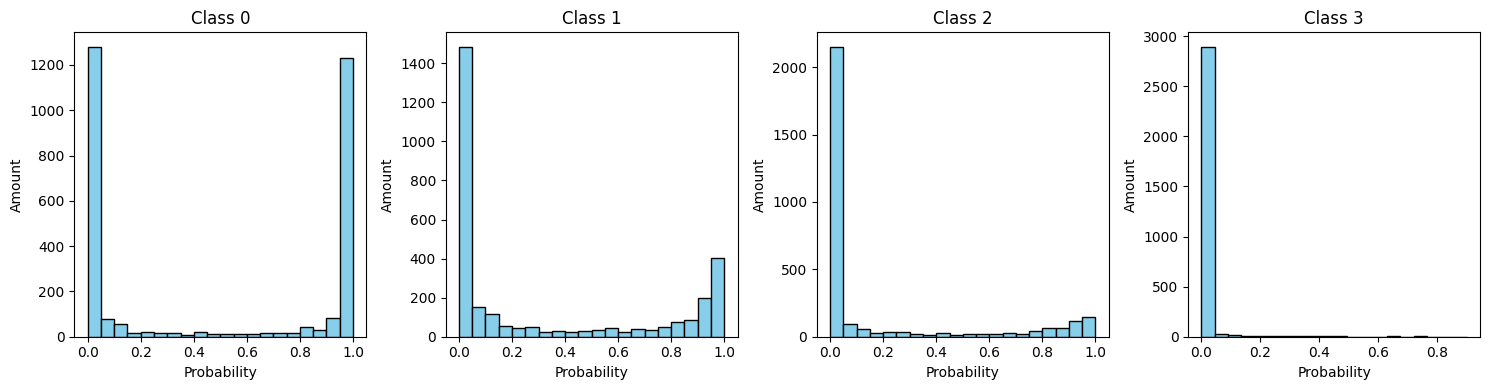

In [93]:
plt.figure(figsize=(15, 4))
for i in range(n_bins):
  plt.subplot(1, n_bins, i+1)
  plt.hist(y_proba_class[:, i], bins=20, color='skyblue', edgecolor='black')
  plt.title(f"Class {i}")
  plt.xlabel("Probability")
  plt.ylabel("Amount")
plt.tight_layout()
plt.show()

свіснув код з методички

In [101]:
# Порівняння перспектив на класифікації

print("=== Порівняння ===")
print("Перспективна задача (Random Forest):")
print(" RMSE = {:.3f}".format(rmse_rf))
print(" MAE = {:.3f}".format(mae_rf))
print("")

print("Класифікаційна задача (Оптимізований Decision Tree):")
acc_clf = accuracy_score(y_test_class, y_pred_dtc_opt)
print(" Accuracy = {:.3f}".format(acc_clf))

# Обчислюємо ширину класу (w) по розмах цільової змінної (R)
# Для дискретизації використовувалось n_bins = 4
n_bins = 4
y_min, y_max = y_test.min(), y_test.max()
R = y_max - y_min  # розмах цільової змінної
w = R / n_bins  # ширина кожного класу

# 1. Перетворення MAE перспектив у точність класифікації:
# Формула: accuracy = 1 - (MAE / w)
acc_from_mae = 1 - (mae_rf / w)

# 2. Перетворення точності класифікації у MAE:
# Формула: MAE = (1 - accuracy) * R + (w / 2)
mae_from_acc = (1 - acc_clf) * R + (w / 2)

print("\n=== Перетворення за формулами ===")
print("MAE перспектив ({:.3f}) отримуємо приблизну точність: {:.3f}".format(mae_rf, acc_from_mae))
print("(Формула: accuracy = 1 - MAE / w, де w = {:.2f})".format(w))
print("")
print("Точності класифікації ({:.3f}) отримуємо приблизну MAE: {:.3f}".format(acc_clf, mae_from_acc))
print("(Формула: MAE = (1 - accuracy) * R + w/2, де R = {:.2f}, w = {:.2f})".format(R, w))


=== Порівняння ===
Перспективна задача (Random Forest):
 RMSE = 3.619
 MAE = 13.096

Класифікаційна задача (Оптимізований Decision Tree):
 Accuracy = 0.912

=== Перетворення за формулами ===
MAE перспектив (13.096) отримуємо приблизну точність: 0.822
(Формула: accuracy = 1 - MAE / w, де w = 73.50)

Точності класифікації (0.912) отримуємо приблизну MAE: 62.622
(Формула: MAE = (1 - accuracy) * R + w/2, де R = 294.00, w = 73.50)


Точність дискретизованих прогнозів регресії = 0.9723333333333334
MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів = 18.694613332578662


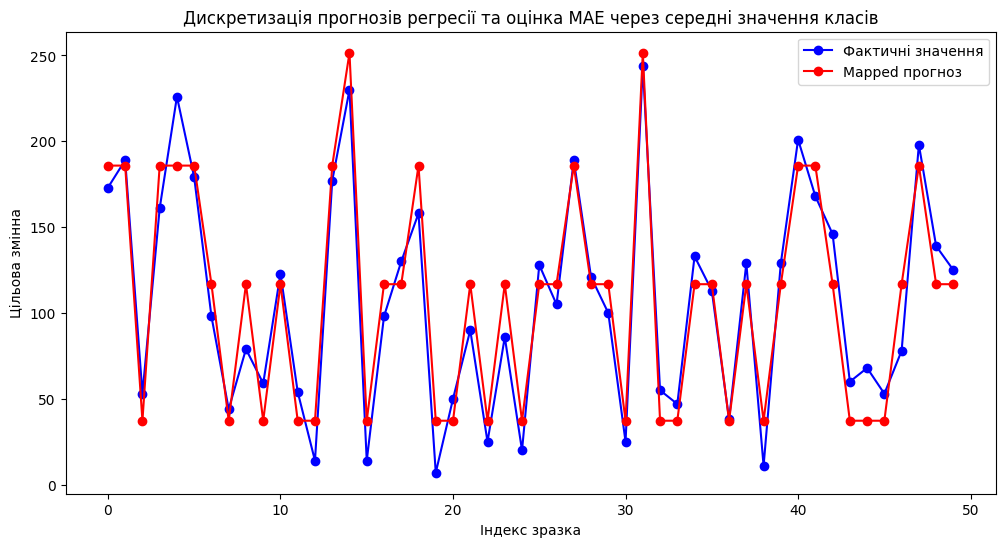

In [102]:
# Використовуємо KBinsDiscretizer, який застосовувався для формування класів (наприклад, n_bins = 4)
# Дискретизуємо регресійні прогнозування з Random Forest
reg_pred_class = kbd.transform(y_pred_rf.reshape(-1, 1)).astype(int).ravel()

# Обчислюємо точність. Дискретизовані прогнози порівнюємо з фактичними класами
accuracy_reg_pred = accuracy_score(y_test_class, reg_pred_class)
print("Точність дискретизованих прогнозів регресії =", accuracy_reg_pred)

## Оцінка MAE через середні значення класів

# Обчислюємо середнє значення цільової змінної для кожного класу (на тренувальних даних)
# y_train_class вже отриманий раніше при дискретизації y_train
class_means = {}
for cls in range(n_bins):
    # Якщо у класі є спостереження, обчислюємо середнє; інакше використовуємо середину інтервалу
    cls_vals = y_train[y_train_class == cls]
    if len(cls_vals) > 0:
        class_means[cls] = cls_vals.mean()
    else:
        # Використовуємо середину інтервалу для цього класу
        bin_edges = kbd.bin_edges_[0]
        class_means[cls] = (bin_edges[cls] + bin_edges[cls+1]) / 2

# Замінюємо дискретизовані прогнозування у середні відповідних класів
mapped_reg_pred = np.array([class_means[cls] for cls in reg_pred_class])

# Обчислюємо MAE між заміненими прогнозами та фактичними значеннями
mae_mapped = np.mean(np.abs(y_test.values - mapped_reg_pred))
print("MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів =", mae_mapped)

# Візуалізація: порівняння фактичних значень та "mapped" прогнозів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, mapped_reg_pred[:50], 'ro-', label='Mapped прогноз')
plt.xlabel("Індекс зразка")
plt.ylabel("Цільова змінна")
plt.title("Дискретизація прогнозів регресії та оцінка MAE через середні значення класів")
plt.legend()
plt.show()

# VI. Оптимізація класифікатора та порівняння з регресією

1. Виконати оптимізацію гіперпараметрів класифікаційної моделі.
2. Знову провести валідацію після оптимізації.
3. Порівняти регресію та класифікацію:
• Чи дало розбиття на класи кращі результати, ніж регресія?
• Як змінюється точність при різному виборі класів?


In [103]:
from sklearn.tree import DecisionTreeClassifier

# Підбираємо параметри для Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
  DecisionTreeClassifier(random_state=42),
  param_grid,
  cv=5,
  scoring='accuracy',
  n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train_class)
print("Найкращі параметри для Decision Tree:", grid_search.best_params_)

# Оцінка оптимізованої моделі
dtc_opt = grid_search.best_estimator_
y_pred_dtc_opt = dtc_opt.predict(X_test_scaled)
MetricsManager.print_classification_metrics(y_test_class, y_pred_dtc_opt, "Оптимізований Decision Tree")

Найкращі параметри для Decision Tree: {'max_depth': None, 'min_samples_split': 5}
Оптимізований Decision Tree - Accuracy: 0.912, Precision: 0.912, Recall: 0.912, F1-score: 0.908
Confusion Matrix
[[1383    9    0    0]
 [  79  849    4    0]
 [   0  129  478    2]
 [   0    0   41   26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1392
           1       0.86      0.91      0.88       932
           2       0.91      0.78      0.84       609
           3       0.93      0.39      0.55        67

    accuracy                           0.91      3000
   macro avg       0.91      0.77      0.81      3000
weighted avg       0.91      0.91      0.91      3000



(0.912, 0.9124290424894697, 0.912, 0.9082447910062265)

In [104]:
rf_reg = RandomForestRegressor(n_estimators=10)
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test_scaled)
mae_rf, rmse_rf, r2_rf = MetricsManager.print_metrics(y_test, y_pred_rf, "Random Forest REGRESSOR")

Random Forest REGRESSOR - MAE: 11.758, RMSE: 3.429, R^2: 0.997


In [105]:
rf_class = RandomForestClassifier(n_estimators=10)
rf_class.fit(X_train_scaled, y_train_class)
y_pred_class = rf_class.predict(X_test_scaled)
acc_rf, prec_rf, rec_rf, f1_rf = MetricsManager.print_classification_metrics(y_test_class, y_pred_class, "Random Forest CLASSIFIER")

Random Forest CLASSIFIER - Accuracy: 0.899, Precision: 0.900, Recall: 0.899, F1-score: 0.892
Confusion Matrix
[[1387    5    0    0]
 [  97  833    2    0]
 [   0  148  461    0]
 [   0    0   52   15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1392
           1       0.84      0.89      0.87       932
           2       0.90      0.76      0.82       609
           3       1.00      0.22      0.37        67

    accuracy                           0.90      3000
   macro avg       0.92      0.72      0.75      3000
weighted avg       0.90      0.90      0.89      3000



In [121]:
# Висновки:
# - Порівнюючи результати, можна визначити, чи дає дискретизація цільової змінної (класифікація)
#   кращі результати, чи ж регресія є більш інформативною.
# - Розподіл ймовірностей показав, як модель впевнено робить прогнози.
# - Ансамблеві підходи (Stacking, Random Forest, Gradient Boosting) здатні покращити результати за відповідними метриками.

In [106]:
# Обчислюємо ширину класу (w) та розмах цільової змінної (R)
# Для дискретизації використовувалось n_bins = 4
n_bins = 4
y_min, y_max = y_test.min(), y_test.max()
R = y_max - y_min          # розмах цільової змінної
w = R / n_bins             # ширина кожного класу

# 1. Перетворення MAE регресії у точність класифікації:
# Формула: accuracy ≈ 1 - (MAE / w)
acc_from_mae = 1 - (mae_rf / w)

# 2. Перетворення точності класифікації у MAE:
# Формула: MAE ≈ (1 - accuracy)*R + (w / 2)
mae_from_acc = (1 - acc_rf) * R + (w / 2)

print("\n=== Перетворення за формулами ===")
print("З MAE регресії ({:.3f}) отримуємо приблизну точність: {:.3f}".format(mae_rf, acc_from_mae))
print("   (Формула: accuracy ≈ 1 - MAE/w, де w = {:.2f})".format(w))
print("")
print("З точності класифікації ({:.3f}) отримуємо приблизну MAE: {:.3f}".format(acc_rf, mae_from_acc))
print("   (Формула: MAE ≈ (1 - accuracy)*R + w/2, де R = {:.2f}, w = {:.2f})".format(R, w))


=== Перетворення за формулами ===
З MAE регресії (11.758) отримуємо приблизну точність: 0.840
   (Формула: accuracy ≈ 1 - MAE/w, де w = 73.50)

З точності класифікації (0.899) отримуємо приблизну MAE: 66.542
   (Формула: MAE ≈ (1 - accuracy)*R + w/2, де R = 294.00, w = 73.50)


показники трошки гірші

Точність дискретизованих прогнозів регресії = 0.9726666666666667
MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів = 18.680451114978162


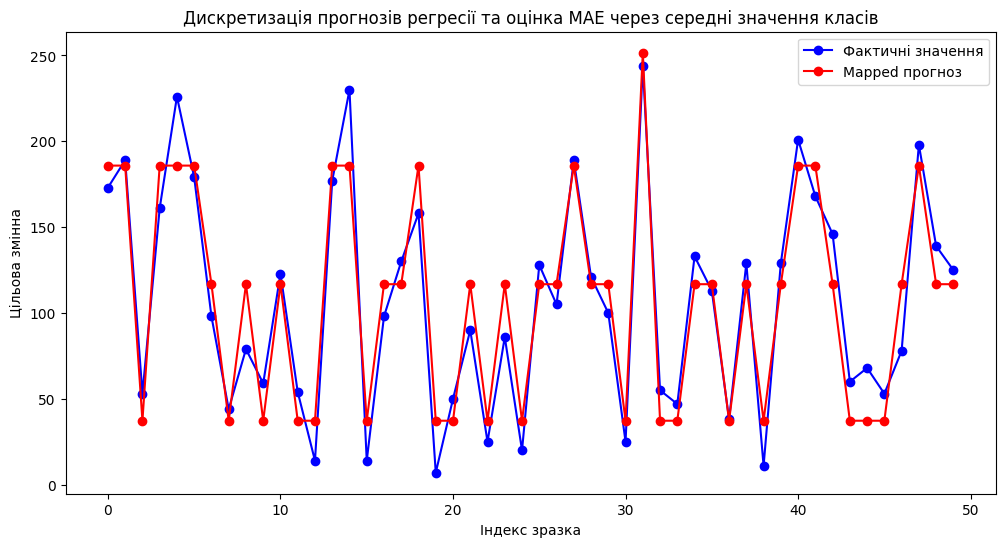

In [107]:

# Використовуємо KBinsDiscretizer, який застосовувався для формування класів (наприклад, n_bins = 4)
# Дискретизуємо регресійні прогнозування з Random Forest
reg_pred_class = kbd.transform(y_pred_rf.reshape(-1, 1)).astype(int).ravel()

# Обчислюємо точність дискретизованих прогнозів порівняно з фактичними класами
accuracy_reg_pred = accuracy_score(y_test_class, reg_pred_class)
print("Точність дискретизованих прогнозів регресії =", accuracy_reg_pred)

# ----- Оцінка MAE через середні значення класів -----

# Обчислюємо середнє значення цільової змінної для кожного класу (на тренувальних даних)
# y_train_class вже отриманий раніше при дискретизації y_train
class_means = {}
for cls in range(n_bins):
    # Якщо у класі є спостереження, обчислюємо середнє; інакше використовуємо середину інтервалу
    cls_vals = y_train[y_train_class == cls]
    if len(cls_vals) > 0:
        class_means[cls] = cls_vals.mean()
    else:
        # Визначаємо середину інтервалу для цього класу
        bin_edges = kbd.bin_edges_[0]
        class_means[cls] = (bin_edges[cls] + bin_edges[cls+1]) / 2

# Замапуємо дискретизовані прогнозування у середні значення відповідних класів
mapped_reg_pred = np.array([class_means[cls] for cls in reg_pred_class])

# Обчислюємо MAE між замапованими прогнозами та фактичними значеннями
mae_mapped = np.mean(np.abs(y_test.values - mapped_reg_pred))
print("MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів =", mae_mapped)

# Візуалізація: порівняння фактичних значень та "mapped" прогнозів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, mapped_reg_pred[:50], 'ro-', label='Mapped прогноз')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Дискретизація прогнозів регресії та оцінка MAE через середні значення класів')
plt.legend()
plt.show()
